## Basic workflow for AL in Fink Stream with ML flow logging

The goal of this notebook is to explore how to set up an Active Learning Loop for the VRA in the Fink ZTF stream with ML flow logging.

We have added a `consumer.py` utility to the `finkvra` package so I should be able to poll the data. Then te question is how to string together the ML prediction, log its results, do the AL sampling, get the labels from a human eyeballer, log that in Ml flow and repeat. 


**Full worklow**

* 1) Poll the stream for initial N alerts 
* 2) Set up real and galactic models on the data
* 3) Initial training and predictions -> Log with ML Flow
* 4) Poll again for N alerts
* 5) Predict -> Log with ML Flow
* 6) AL strategy: choose samples and ask eyeballer for labels -> Log in ML Flow
* 7) Retrain -> Log ML Flow
* [...] Repeat

# This notebook

Get familiar with the data we poll from the stream. 
Noticed that I need to sherlock data to remove AGNs and SNe



## 1. Poll ZTF stream for initial alerts N=20

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from finkvra.utils import consumer as finkconsumer


In [2]:
finkconsumer.poll_n_alerts?

Signature:
finkconsumer.poll_n_alerts(
    myconfig,
    topics,
    n=10,
    outidr='~/Data/FinkZTFStream/',
) -> None
Docstring:
Connect to and poll fink servers once.

Parameters
----------
myconfig: dic
    python dictionnary containing credentials
topics: list of str
    List of string with topic names
File:      ~/software/finkvra/finkvra/utils/consumer.py
Type:      function

In [3]:
myconfig = {
    'bootstrap.servers': 'kafka-ztf.fink-broker.org:24499',
    'group.id': 'heloise_test6'
}
topics = ['fink_vra_ztf'] # the fink VRA filter I made with Julien in May 2025

In [4]:
finkconsumer.poll_n_alerts(myconfig, topics, n=50)

2025-05-30 11:47:25,384 [INFO] finkvra.utils.consumer.poll_n_alerts: Polling 50 alerts from topics: ['fink_vra_ztf']
2025-05-30 11:47:30,388 [INFO] finkvra.utils.consumer.poll_n_alerts: No alerts received in the last 5 seconds.


Note: the Data is saved to `~/Data/FinkZTFStream/` instead of being returned, and the `finkconsumer.poll_n_alerts` function isn't very verbose so hard to tell what's going on. 

- [x] **Add logging to** `finkconsumer.poll_n_alerts` 


### Reading the alerts from my local directory

In [2]:
data = pd.read_parquet('/home/stevance/Data/FinkZTFStream/20250602_082304_alerts.parquet')

In [3]:
data

,candid,objectId,ra,dec,drb,mjd,mag,maglim,fid,isdiffpos,lc_features_g,lc_features_r,sherl_class,sep_arcsec
20,3069386415315015051,ZTF25aastlyj,288.662154,65.088530,0.961113,"[60823.38641199982, 60795.374525499996, 60795....","[19.527942657470703, nan, nan, nan, nan, nan, ...","[20.746294021606445, 20.559799194335938, 20.42...","[1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, ...","[t, None, None, None, None, None, None, None, ...","{'amplitude': 0.0, 'anderson_darling_normal': ...","{'amplitude': None, 'anderson_darling_normal':...",ORPHAN,nan
29,3069387894915010012,ZTF25aastmkd,341.846733,72.183242,0.994998,"[60823.38789349981, 60795.426064800005, 60795....","[19.923898696899414, nan, nan, nan, nan, nan, ...","[20.43282127380371, 20.07029914855957, 20.3325...","[1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, ...","[f, None, None, None, None, None, None, None, ...","{'amplitude': 0.0, 'anderson_darling_normal': ...","{'amplitude': None, 'anderson_darling_normal':...",ORPHAN,nan
32,3069382582215015014,ZTF25aastlfp,293.757494,24.732624,0.999734,"[60823.382581000216, 60794.36778939981, 60796....","[19.765827178955078, nan, nan, nan, nan, nan, ...","[20.979511260986328, 19.194499969482422, 20.71...","[1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, ...","[t, None, None, None, None, None, None, None, ...","{'amplitude': 0.0, 'anderson_darling_normal': ...","{'amplitude': None, 'anderson_darling_normal':...",SN,1.2398935354229732


In [4]:
lasair_base_url = 'https://lasair-ztf.lsst.ac.uk/objects/'

https://lasair-ztf.lsst.ac.uk/objects/ZTF19aanxupt/ is an AGN

-> **I could use the Lasair API to grab the sherlock data** 

Then again we won't have a bgi repository of AGNs in first year of LSST so maybe not relying on that would be good.

In [5]:
fid2col_dict={1:'navy', 2:'orange'}

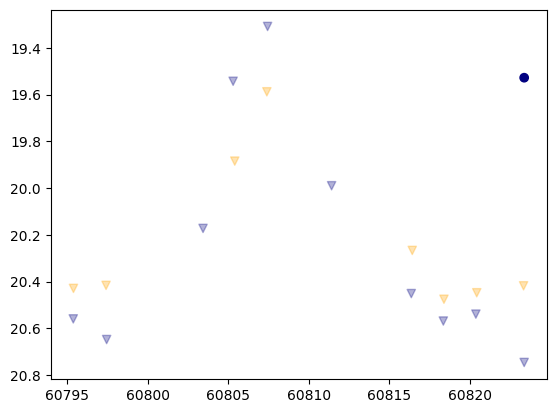

In [6]:
plt.scatter(data.iloc[0].mjd, data.iloc[0].mag, 
            c=[fid2col_dict[fid] for fid in data.iloc[0].fid])
plt.scatter(data.iloc[0].mjd, data.iloc[0].maglim, 
            c=[fid2col_dict[fid] for fid in data.iloc[0].fid], alpha=0.3, marker ='v')
plt.gca().invert_yaxis()

ZTF Gives **30 days history** in the packets. 

_Easy features I can calculate_
- N dets with mag brighter than non dets


_What features can I poach?_

The link https://github.com/astrolabsoftware/fink-science/tree/master/fink_science/ad_features is broken. **For now just do everything**


In [7]:
data.iloc[0]['lc_features_g']

{'amplitude': 0.0889855545874525,
 'anderson_darling_normal': 0.46326638170649537,
 'beyond_1_std': 0.2222222222222222,
 'chi2': 0.33593972251719717,
 'cusum': 0.33384228466873633,
 'inter_percentile_range_10': 0.13269743469322748,
 'kurtosis': 1.6779295399609637,
 'linear_fit_reduced_chi2': 0.27547956997842105,
 'linear_fit_slope': 0.0018460531551792265,
 'linear_fit_slope_sigma': 0.002118738228307318,
 'linear_trend': 0.0023707633108586345,
 'linear_trend_noise': 0.04740620596438159,
 'linear_trend_sigma': 0.0015132942911012998,
 'magnitude_percentage_ratio_20_10': 0.46396335090897806,
 'magnitude_percentage_ratio_40_5': 0.15540172247059275,
 'maximum_slope': 0.02908475906962211,
 'mean': 18.692279695203148,
 'mean_variance': 0.002757038799239993,
 'median': 18.680202192653496,
 'median_absolute_deviation': 0.02869608081787689,
 'median_buffer_range_percentage_10': 0.3333333333333333,
 'percent_amplitude': 0.09542628539689346,
 'skew': -0.8953212089680165,
 'standard_deviation': 0.05


#### As a first aproach I'm not going to calculate anything, I'm going to use what's natively in Fink

### Make `X` from the data table

In [7]:
lc_features_g_series = []
lc_features_r_series = []
context = [] # ra, dec, drb
for i in range(data.shape[0]):
    context.append(data.iloc[i][['candid','objectId','ra', 'dec', 'drb']])
    lc_features_g_series.append(pd.Series(data.iloc[i]['lc_features_g']))
    lc_features_r_series.append(pd.Series(data.iloc[i]['lc_features_r']))

In [8]:
pd.DataFrame(lc_features_g_series)

,amplitude,anderson_darling_normal,beyond_1_std,chi2,cusum,inter_percentile_range_10,kurtosis,linear_fit_reduced_chi2,linear_fit_slope,linear_fit_slope_sigma,...,mean,mean_variance,median,median_absolute_deviation,median_buffer_range_percentage_10,percent_amplitude,skew,standard_deviation,stetson_K,weighted_mean
0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,19.527943,NaN,19.527943,0.0,0.0,0.0,NaN,NaN,NaN,19.527943
1,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,19.923899,NaN,19.923899,0.0,0.0,0.0,NaN,NaN,NaN,19.923899
2,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,19.765827,NaN,19.765827,0.0,0.0,0.0,NaN,NaN,NaN,19.765827


#### There's quite a lot of NaN values there... Maybe should try to make my own dumb LC features after all

## N dets with mag brighter than non dets

In [9]:
ndets = sum(~pd.isna(data.iloc[0]['mag']))
nnondets = sum(pd.isna(data.iloc[0]['mag']))
dets_median = np.nanmedian(data.iloc[0]['mag'])
dets_std = np.nanstd(data.iloc[0]['mag'])

In [10]:
def vra_lc_feats(row):
    ndets = sum(~pd.isna(row['mag']))
    nnondets = sum(pd.isna(row['mag']))
    dets_median = np.nanmedian(row['mag'])
    dets_std = np.nanstd(row['mag'])
    return ndets, nnondets, dets_median, dets_std

In [11]:
feat_df = data.apply(lambda row: vra_lc_feats(row), axis=1, result_type='expand')
feat_df.columns = ['ndets', 'nnondets', 'dets_median', 'dets_std']
data = data.join(feat_df)

In [12]:
data

,candid,objectId,ra,dec,drb,mjd,mag,maglim,fid,isdiffpos,lc_features_g,lc_features_r,sherl_class,sep_arcsec,ndets,nnondets,dets_median,dets_std
20,3069386415315015051,ZTF25aastlyj,288.662154,65.088530,0.961113,"[60823.38641199982, 60795.374525499996, 60795....","[19.527942657470703, nan, nan, nan, nan, nan, ...","[20.746294021606445, 20.559799194335938, 20.42...","[1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, ...","[t, None, None, None, None, None, None, None, ...","{'amplitude': 0.0, 'anderson_darling_normal': ...","{'amplitude': None, 'anderson_darling_normal':...",ORPHAN,nan,1.0,17.0,19.527943,0.0
29,3069387894915010012,ZTF25aastmkd,341.846733,72.183242,0.994998,"[60823.38789349981, 60795.426064800005, 60795....","[19.923898696899414, nan, nan, nan, nan, nan, ...","[20.43282127380371, 20.07029914855957, 20.3325...","[1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, ...","[f, None, None, None, None, None, None, None, ...","{'amplitude': 0.0, 'anderson_darling_normal': ...","{'amplitude': None, 'anderson_darling_normal':...",ORPHAN,nan,1.0,20.0,19.923899,0.0
32,3069382582215015014,ZTF25aastlfp,293.757494,24.732624,0.999734,"[60823.382581000216, 60794.36778939981, 60796....","[19.765827178955078, nan, nan, nan, nan, nan, ...","[20.979511260986328, 19.194499969482422, 20.71...","[1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, ...","[t, None, None, None, None, None, None, None, ...","{'amplitude': 0.0, 'anderson_darling_normal': ...","{'amplitude': None, 'anderson_darling_normal':...",SN,1.2398935354229732,1.0,17.0,19.765827,0.0


In [13]:
lc_features_g_series = []
lc_features_r_series = []
vra_features = [] # ra, dec, drb, 'ndets', 'nnondets', 'dets_median', 'dets_std'
for i in range(data.shape[0]):
    vra_features.append(data.iloc[i][['candid','objectId','ra', 'dec', 'drb', 'ndets', 'nnondets', 'dets_median', 'dets_std']])
    lc_features_g_series.append(pd.Series(data.iloc[i]['lc_features_g']))
    lc_features_r_series.append(pd.Series(data.iloc[i]['lc_features_r']))

In [14]:
X = pd.DataFrame(vra_features).join(pd.DataFrame(lc_features_g_series)).join(pd.DataFrame(lc_features_g_series), rsuffix='r_')

In [15]:
X

,candid,objectId,ra,dec,drb,ndets,nnondets,dets_median,dets_std,amplitude,...,meanr_,mean_variancer_,medianr_,median_absolute_deviationr_,median_buffer_range_percentage_10r_,percent_amplituder_,skewr_,standard_deviationr_,stetson_Kr_,weighted_meanr_
20,3069386415315015051,ZTF25aastlyj,288.662154,65.088530,0.961113,1.0,17.0,19.527943,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,3069387894915010012,ZTF25aastmkd,341.846733,72.183242,0.994998,1.0,20.0,19.923899,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,3069382582215015014,ZTF25aastlfp,293.757494,24.732624,0.999734,1.0,17.0,19.765827,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


61 is a lot of features - not that many but still. Especially if I want to make models with few samples. 
Let's review the features now (**do again later when I have the manual**)

* amplitude: guessing the amplitude of the LC -> **YES**
* anderson_darling_normal: No idea
* beyond_1_std: no idea 
* chi2: Goodness of fit
* cusum: Cumulative sum of what?
* inter_percentile_range_10: no idea 
* kurtosis: no idea 
* linear_fit_reduced_chi2: chi2 of a linear fit. Could be usefull, **YES**
* linear_fit_slope: **YES**
* linear_fit_slope_sigma: **YES**
* linear_trend: Not sure since we had the slope
* linear_trend_noise
* linear_trend_sigma
* magnitude_percentage_ratio_20_10: no idea
* magnitude_percentage_ratio_40_5: no idea
* maximum_slope: Max slope from the linear fit??
* mean: Mean mag (nice that it's split by colour)
* mean_variance: 
* median: **YES**
* median_absolute_deviation: hmmm not sure - probably measure of scatter **YES**
* median_buffer_range_percentage_10*: dunno
* percent_amplitude: No idea
* skew: no idea
* standard_deviation: no idea,
* stetson_K: no idea
* weighted_mean: weighted by what? errors?

the median is a bit redundant with mine but their's is split by colour

In [16]:
lc_features_to_keep = ['amplitude', 
                       'linear_fit_reduced_chi2', 
                       'linear_fit_slope', 
                       'linear_fit_slope_sigma', 
                       'median', 
                       'median_absolute_deviation']

In [17]:
lc_features_g_series = []
lc_features_r_series = []
vra_features = [] # ra, dec, drb, 'ndets', 'nnondets', 'dets_median', 'dets_std'
for i in range(data.shape[0]):
    vra_features.append(data.iloc[i][['candid','objectId','ra', 'dec', 'drb', 'ndets', 'nnondets', 'dets_median', 'dets_std']])
    lc_features_g_series.append(pd.Series(data.iloc[i]['lc_features_g'])[lc_features_to_keep])
    lc_features_r_series.append(pd.Series(data.iloc[i]['lc_features_r'])[lc_features_to_keep])

In [18]:
X = pd.DataFrame(vra_features).join(pd.DataFrame(lc_features_g_series)).join(pd.DataFrame(lc_features_g_series), rsuffix='r_')

In [19]:
X

,candid,objectId,ra,dec,drb,ndets,nnondets,dets_median,dets_std,amplitude,...,linear_fit_slope,linear_fit_slope_sigma,median,median_absolute_deviation,amplituder_,linear_fit_reduced_chi2r_,linear_fit_sloper_,linear_fit_slope_sigmar_,medianr_,median_absolute_deviationr_
20,3069386415315015051,ZTF25aastlyj,288.662154,65.088530,0.961113,1.0,17.0,19.527943,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,3069387894915010012,ZTF25aastmkd,341.846733,72.183242,0.994998,1.0,20.0,19.923899,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,3069382582215015014,ZTF25aastlfp,293.757494,24.732624,0.999734,1.0,17.0,19.765827,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### E(B-V)

In [20]:
from astropy.coordinates import SkyCoord
from dustmaps.sfd import SFDQuery

Configuration file not found:

    /home/stevance/.dustmapsrc

To create a new configuration file in the default location, run the following python code:

    from dustmaps.config import config
    config.reset()

Note that this will delete your configuration! For example, if you have specified a data directory, then dustmaps will forget about its location.


In [21]:
from dustmaps.config import config
config.reset()

In [23]:
# first we put our RA and DEC in an Astropy SkyCoord object 
coords = SkyCoord(str(X.iloc[0].ra), str(X.iloc[0].dec), frame='icrs', unit='deg')

In [24]:
# Then we use the SFD object to get an E(B-V)
sfd = SFDQuery()
ebv = sfd(coords)

In [25]:
ebv

0.108659916

In [26]:
def get_ebv(ra, dec, sfd=sfd):
    """Function to grab the E(B-V) value from the SFD dust map.
    This can also used to compute the extinction for a bunch of rows
    using the .apply function of pandas dataframes

    Parameters:
        ra (float): Right Ascension in degrees.
        dec (float): Declination in degrees.
    Returns:
        ebv (float): E(B-V) value at the given coordinates.
    """
    # Create a SkyCoord object from the RA and Dec values
    coord = SkyCoord(ra=ra, dec=dec, unit='deg', frame='icrs')
    
    # Query the SFD dust map for E(B-V) at the given coordinates
    ebv = sfd(coord)
    
    return ebv

In [28]:
X.apply(lambda row: get_ebv(row.ra, row.dec), axis=1)

20    0.108660
29    0.438332
32    1.916294
dtype: float32

### Get Labels from "eyeballer" (me)

Let's make the URLs from our X.objectId. I can put the labels in a `y` dataframe

In [21]:
for i in range(X.shape[0]):
    print(f"[{X.iloc[i].objectId}]({lasair_base_url}{X.iloc[i].objectId})\n")

[ZTF19aanxupt](https://lasair-ztf.lsst.ac.uk/objects/ZTF19aanxupt)

[ZTF21aazlmcm](https://lasair-ztf.lsst.ac.uk/objects/ZTF21aazlmcm)

[ZTF20aajcoxk](https://lasair-ztf.lsst.ac.uk/objects/ZTF20aajcoxk)

[ZTF20aaigcjx](https://lasair-ztf.lsst.ac.uk/objects/ZTF20aaigcjx)

[ZTF20abfqwds](https://lasair-ztf.lsst.ac.uk/objects/ZTF20abfqwds)

[ZTF20aawfplj](https://lasair-ztf.lsst.ac.uk/objects/ZTF20aawfplj)

[ZTF25aasihwb](https://lasair-ztf.lsst.ac.uk/objects/ZTF25aasihwb)

[ZTF25aashymb](https://lasair-ztf.lsst.ac.uk/objects/ZTF25aashymb)

[ZTF20abiinjj](https://lasair-ztf.lsst.ac.uk/objects/ZTF20abiinjj)

[ZTF25aasgxxa](https://lasair-ztf.lsst.ac.uk/objects/ZTF25aasgxxa)

[ZTF25aasgyah](https://lasair-ztf.lsst.ac.uk/objects/ZTF25aasgyah)

[ZTF20aacczdh](https://lasair-ztf.lsst.ac.uk/objects/ZTF20aacczdh)

[ZTF21acrafyc](https://lasair-ztf.lsst.ac.uk/objects/ZTF21acrafyc)

[ZTF25aagpvzu](https://lasair-ztf.lsst.ac.uk/objects/ZTF25aagpvzu)

[ZTF23abovfmk](https://lasair-ztf.lsst.ac.uk/obj

[ZTF19aanxupt](https://lasair-ztf.lsst.ac.uk/objects/ZTF19aanxupt)

[ZTF21aazlmcm](https://lasair-ztf.lsst.ac.uk/objects/ZTF21aazlmcm)

[ZTF20aajcoxk](https://lasair-ztf.lsst.ac.uk/objects/ZTF20aajcoxk)

[ZTF20aaigcjx](https://lasair-ztf.lsst.ac.uk/objects/ZTF20aaigcjx)

[ZTF20abfqwds](https://lasair-ztf.lsst.ac.uk/objects/ZTF20abfqwds)

[ZTF20aawfplj](https://lasair-ztf.lsst.ac.uk/objects/ZTF20aawfplj)

[ZTF25aasihwb](https://lasair-ztf.lsst.ac.uk/objects/ZTF25aasihwb)

[ZTF25aashymb](https://lasair-ztf.lsst.ac.uk/objects/ZTF25aashymb)

[ZTF20abiinjj](https://lasair-ztf.lsst.ac.uk/objects/ZTF20abiinjj)

[ZTF25aasgxxa](https://lasair-ztf.lsst.ac.uk/objects/ZTF25aasgxxa)

[ZTF25aasgyah](https://lasair-ztf.lsst.ac.uk/objects/ZTF25aasgyah)

[ZTF20aacczdh](https://lasair-ztf.lsst.ac.uk/objects/ZTF20aacczdh)

[ZTF21acrafyc](https://lasair-ztf.lsst.ac.uk/objects/ZTF21acrafyc)

[ZTF25aagpvzu](https://lasair-ztf.lsst.ac.uk/objects/ZTF25aagpvzu)

[ZTF23abovfmk](https://lasair-ztf.lsst.ac.uk/objects/ZTF23abovfmk)

[ZTF19adcfdkh](https://lasair-ztf.lsst.ac.uk/objects/ZTF19adcfdkh)

[ZTF19aadfktv](https://lasair-ztf.lsst.ac.uk/objects/ZTF19aadfktv)

[ZTF25aasovvc](https://lasair-ztf.lsst.ac.uk/objects/ZTF25aasovvc)

[ZTF21abbojda](https://lasair-ztf.lsst.ac.uk/objects/ZTF21abbojda)

[ZTF19aaslfxe](https://lasair-ztf.lsst.ac.uk/objects/ZTF19aaslfxe)



In [22]:
y = ['AGN', 
     'AGN',
     'VS', # I thought we removed all the VS
     'AGN', 
     'AGN',
     'AGN',
     'None', # not found in fink or Lasair
     'VS',
     'VS',
     'ORPHAN', #maybe bad
     'BOGUS', #bad ref
     'VS', 
     'VS',
     'AGN',
     'AGN',
     'AGN',
     'VS', 
     'None',
     'VS',
     'AGN',
    ]

### We're gonna need sherlock...

Too many AGNs, and VS left over even after the filtering. 

## TODO Next:

* Use the Lasair API to grab the Sherlock data
* Exclude AGNs and VS from my pool 
* Get the separation as a feature for what's left over

## 1-bis: Grab sherlock data from Lasair

In [34]:
import lasair
import os
import json

In [30]:
# the lasair client will be used for fetching Sherlock data
L = lasair.lasair_client(os.environ.get('LASAIR_TOKEN'), endpoint='https://lasair-ztf.lsst.ac.uk/api')

In [49]:
sherl = L.sherlock_position(data.iloc[0]['ra'], data.iloc[0]['dec'], lite=False)

In [37]:
sherl['classifications']['transient_00000'][0]

'AGN'

In [39]:
sherl['crossmatches'][0]['separationArcsec']

0.3634766203421729

In [46]:
sherl_class = []
sherl_separcsec = []

for i in range(data.shape[0]):
    _sherl = L.sherlock_position(data.iloc[i]['ra'], data.iloc[i]['dec'], lite=False)
    sherl_class.append(_sherl['classifications']['transient_00000'][0])
    try:
        sherl_separcsec.append(_sherl['crossmatches'][0]['separationArcsec'])
    except IndexError:
        sherl_separcsec.append(np.nan)

this is quite slow because have to do sherlock calls one by one

In [47]:
sherl_class

['AGN',
 'AGN',
 'VS',
 'AGN',
 'AGN',
 'AGN',
 'SN',
 'VS',
 'VS',
 'ORPHAN',
 'ORPHAN',
 'VS',
 'VS',
 'AGN',
 'AGN',
 'AGN',
 'VS',
 'ORPHAN',
 'VS',
 'AGN']

In [48]:
sherl_separcsec

[0.3634766203421729,
 0.34561094658560276,
 0.12224989238549991,
 0.07214745987879574,
 0.25739325698440124,
 0.2488275505703162,
 11.220050833381997,
 1.0914603291448093,
 0.41165392036879117,
 nan,
 nan,
 0.04112176637558314,
 0.5489856693756705,
 0.24259914684751535,
 0.24329906569943494,
 0.38400138098175796,
 0.3364698434482272,
 nan,
 0.0981143063724406,
 0.6125077579658013]

In [53]:
data.join(pd.DataFrame(np.atleast_2d([sherl_class, sherl_separcsec]).T, columns=['sherl_class', 'sep_arcsec']))

,candid,objectId,ra,dec,drb,mjd,mag,maglim,fid,lc_features_g,lc_features_r,ndets,nnondets,dets_median,dets_std,sherl_class,sep_arcsec
0,3068299254115015013,ZTF19aanxupt,215.866596,-8.584876,0.999964,"[60822.29925929988, 60794.31987270014, 60794.3...","[19.73056983947754, 19.649499893188477, 19.653...","[20.168989181518555, 20.210899353027344, 20.04...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, ...","{'amplitude': 0.0889855545874525, 'anderson_da...","{'amplitude': 0.04189712620773456, 'anderson_d...",16.0,2.0,19.666651,0.098708,AGN,0.3634766203421729
1,3068299253115010004,ZTF21aazlmcm,214.181838,-11.466671,0.999993,"[60822.29925929988, 60794.31987270014, 60794.3...","[19.718433380126953, 19.744800567626953, nan, ...","[20.201236724853516, 20.265199661254883, 19.99...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, ...","{'amplitude': 0.10481508251287153, 'anderson_d...","{'amplitude': 0.07152319243344074, 'anderson_d...",14.0,4.0,19.748200,0.067737,AGN,0.34561094658560276
2,3068301500515015010,ZTF20aajcoxk,206.819797,-5.025128,0.999974,"[60822.30150459986, 60795.25657409988, 60795.2...","[20.0477237701416, nan, 20.28849983215332, nan...","[20.356197357177734, 20.488500595092773, 20.41...","[1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1]","{'amplitude': 0.056522341237133844, 'anderson_...","{'amplitude': 0.008201653912088602, 'anderson_...",6.0,6.0,20.126862,0.261365,VS,0.12224989238549991
3,3068301040915010005,ZTF20aaigcjx,212.105950,-4.928500,0.999995,"[60822.301041699946, 60796.298738399986, 60796...","[19.915971755981445, nan, nan, nan, 20.0750999...","[20.27997589111328, 20.667699813842773, 20.717...","[1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2]","{'amplitude': 0.036173002449437774, 'anderson_...","{'amplitude': 0.05823865295848485, 'anderson_d...",9.0,7.0,20.021099,0.101441,AGN,0.07214745987879574
4,3068298781015010009,ZTF20abfqwds,223.002619,-13.154510,0.999914,"[60822.29878470022, 60796.29603009997, 60796.3...","[19.7941837310791, nan, 19.776899337768555, 19...","[20.269792556762695, 20.584299087524414, 20.55...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, ...","{'amplitude': 0.02279264101152023, 'anderson_d...","{'amplitude': 0.040600431117978175, 'anderson_...",12.0,5.0,19.791292,0.074670,AGN,0.25739325698440124
5,3068300554415010000,ZTF20aawfplj,219.332287,13.400803,0.999973,"[60822.30055559985, 60794.316689800005, 60794....","[20.09563636779785, nan, 20.090299606323242, 2...","[20.513275146484375, 20.359500885009766, 20.57...","[1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, ...","{'amplitude': 0.11523281604381097, 'anderson_d...","{'amplitude': None, 'anderson_darling_normal':...",9.0,9.0,20.083000,0.094845,AGN,0.2488275505703162
6,3068298784315015031,ZTF25aasihwb,223.892487,-9.480765,0.999939,"[60822.29878470022, 60796.29603009997, 60796.3...","[19.72616958618164, nan, nan, nan, nan, nan, n...","[20.330307006835938, 20.65850067138672, 20.606...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, ...","{'amplitude': 0.0, 'anderson_darling_normal': ...","{'amplitude': None, 'anderson_darling_normal':...",1.0,16.0,19.726170,0.000000,SN,11.220050833381997
7,3068298784315015037,ZTF25aashymb,223.637829,-9.366106,0.999741,"[60822.29878470022, 60796.29603009997, 60796.3...","[20.124170303344727, nan, nan, nan, nan, nan, ...","[20.330307006835938, 20.65850067138672, 20.606...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, ...","{'amplitude': 0.0, 'anderson_darling_normal': ...","{'amplitude': None, 'anderson_darling_normal':...",1.0,16.0,20.124170,0.000000,VS,1.0914603291448093
8,3068298782315010015,ZTF20abiinjj,225.500214,-11.406157,0.992631,"[60822.29878470022, 60796.29603009997, 60796.3...","[19.779403686523438, nan, nan, nan, nan, nan, ...","[20.43389320373535, 20.7185001373291, 20.75889...","[1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2]","{'amplitude': 0.0, 'anderson_darling_normal': ...","{'amplitude': None, 'anderson_darling_normal':...",1.0,15.0,19.779404,0.000000,VS,0.41165392036879117
9,3068250212815010015,ZTF25a

### Add to my fink ingester the sherlock call 